# Measuring monotonic relationships

The Spearman Rank Correlation Coefficient allows us to determine whether or not two data series move together; that is, when one increases (decreases) the other also increases (decreases). This is more general than a linear relationship; for instance, $y = e^x$ is a monotonic function, but not a linear one. Therefore, in computing it we compare not the raw data but the ranks of the data.

This is useful when your data sets may be in different units, and therefore not linearly related (for example, the price of a square plot of land and its side length, since the price is more likely to be linear in the area). It's also suitable for data sets which not satisfy the assumptions that other tests require, such as the observations being normally distributed as would be necessary for a t-test.

In [31]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

In [19]:
# Example of ranking data
l = [10, 9, 5, 7, 5]
print 'Raw data: ', l
print 'Ranking: ', list(stats.rankdata(l, method='average'))

Raw data:  [10, 9, 5, 7, 5]
Ranking:  [5.0, 4.0, 1.5, 3.0, 1.5]


The argument `method='average'` indicates that when we have a tie, we average the ranks that the numbers would occupy. For example, the two 5's above, which would take up ranks 1 and 2, each get assigned a rank of $1.5$.

To compute the Spearman rank correlation for two data sets $X$ and $Y$, each of size $n$, we use the formula
$$r_S = 1 - \frac{6 \sum_{i=1}^n d_i^2}{n(n^2 - 1)}$$

where $d_i$ is the difference between the ranks of the $i$th pair of observations, $X_i - Y_i$.

The result will always be between $-1$ and $1$. A positive value indicates a positive relationship between the variables, while a negative value indicates an inverse relationship. A value of 0 implies the absense of any monotonic relationship. This does not mean that there is no relationship; for instance, if $Y$ is equal to $X$ with a delay of 2, they are related simply and precisely, but their $r_S$ can be close to zero:

In [47]:
X = np.random.rand(100)
Xrank = stats.rankdata(sample, method='average')
Yrank = stats.rankdata([1,1] + list(sample[:98]), method='average')

diffs = Xrank - Yrank # order doesn't matter since we'll be squaring these values
rs = 1 - 6*sum(diffs*diffs)/999900
print rs

-0.0058595859586


We can also use the `spearmanr` function in the `scipy.stats` library:

In [48]:
# Generate two random data sets and rank them
np.random.seed(161)
Xrank = stats.rankdata(np.random.rand(10), method='average')
Yrank = stats.rankdata(np.random.rand(10), method='average')

rs = stats.spearmanr(Xrank, Yrank)
print 'Spearman ratio: ', rs[0]
print 'p-value: ', rs[1]

Spearman ratio:  0.236363636364
p-value:  0.510885317515


We now have ourselves an $r_S$, but how do we interpret it? It's positive, so we know that the variables are not anticorrelated. It's not very large, so we know they aren't perfectly positively correlated, but it's hard to say from a glance just how significant the correlation is. Luckily, `spearmanr` also computes the p-value for this ratio and sample size for us. We can see that the p-value here is very large; therefore, we cannot claim that $X$ and $Y$ are correlated.

Now that we've seen how Spearman rank correlation works, we'll quickly go through the process again with some real data. For instance, we may wonder whether the expense ratio of a mutual fund is indicative of its three-year Sharpe ratio. That is, does spending more money on administration, management, etc. lower the risk or increase the returns? Quantopian does not currently support mutual funds, so we will pull the data from Yahoo Finance.

In [39]:
# Copying data for DXHLX, UGPIX, ALQIX, IIRFX, TMSCX, FHKCX, MCDFX, NRICX, PINHX, ANGLX
expense = [1.35, 1.79, 1.45, 1.88, 1., 1.01, 1.19, 1.92, 0.51, 1.24]
sharpe = [0.9, 1., 1.11, 0.1, 1.01, 1.69, 1.62, 1.83, 1.94, 2.16]

r_S = stats.spearmanr(expense, sharpe)
print 'Spearman ratio: ', r_S[0]
print 'p-value: ', r_S[1]

Spearman ratio:  -0.369696969697
p-value:  0.293050075293


It looks as though the expense ratio and Sharpe ratio may in fact be anticorrelated. However, according to the p-value of this result, the correlation is significant only with probability $\approx 70\%$.

One strategy in building portfolios is diversification, which lowers risk by combining securities which are relatively uncorrelated. That way, even if one of them falls, the same factors are unlikely to cause the other to fall. For instance, we might buy shares of Yahoo and the SPDR utilities fund:

YHOO and XLU
Spearman ratio:  0.109520857159  p-value:  0.083329029636
YHOO and SPY
Spearman ratio:  0.54078467084  p-value:  1.82473959848e-20
XLU and SPY
Spearman ratio:  0.36273827565  p-value:  3.1987123265e-09


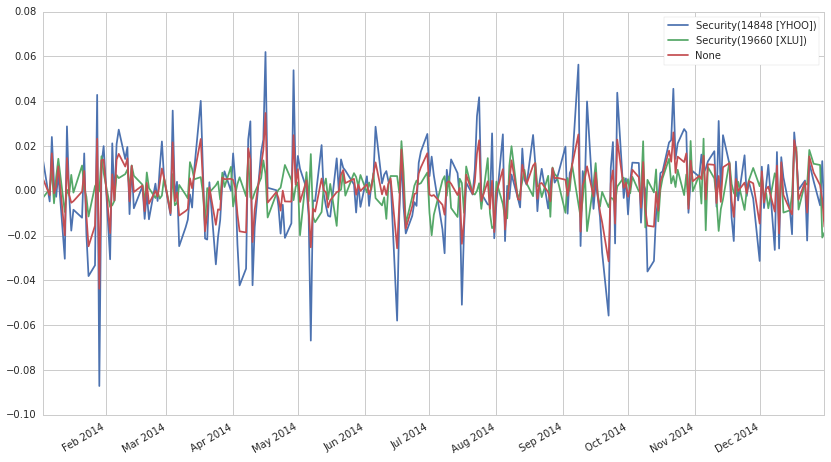

In [88]:
# Load pricing data for the two securities
start = '2014-01-01'
end = '2015-01-01'
asset = get_pricing('YHOO', fields='price', start_date=start, end_date=end).pct_change()[1:]
complement = get_pricing('XLU', fields='price', start_date=start, end_date=end).pct_change()[1:]
benchmark = get_pricing('SPY', fields='price', start_date=start, end_date=end).pct_change()[1:]

r_S = stats.spearmanr(asset, complement)
print 'YHOO and XLU'
print 'Spearman ratio: ', r_S[0], ' p-value: ', r_S[1]
print 'YHOO and SPY'
r_S = stats.spearmanr(asset, benchmark)
print 'Spearman ratio: ', r_S[0], ' p-value: ', r_S[1]
print 'XLU and SPY'
r_S = stats.spearmanr(complement, benchmark)
print 'Spearman ratio: ', r_S[0], ' p-value: ', r_S[1]

asset.plot()
complement.plot()
portfolio = (asset + complement)/2 # We can diversify our portfolio by including both stocks
portfolio.plot()
plt.legend();

The p-value here is very low because of the number of samples. Note that stocks tend to be fairly highly correlated and move with the market, as evidenced by the improbably high Spearman ratio between each security and the S&P 500, so in this context the correlation of the two stocks can be considered low. Even though the portfolio (red) does not perform as well as the stock on top, it may be a good choice because neither of the two stocks is consistently better than the other and because the portfolio is less volatile than either of them.